In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import os

# To plot pretty figures
#%matplotlib inline
# import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "lab10"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


def get_path(fig_name, fig_extension="png"):
    path = os.path.join(IMAGES_PATH, fig_name + "." + fig_extension)
    return path


# Grover's algorithm

In [2]:
from qiskit import QuantumCircuit, transpile, QuantumRegister,ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.circuit.library import UnitaryGate
import math

In [3]:
from qiskit.circuit.library import MCXGate

def oracle(n,binstr):  
    instr = QuantumCircuit(n+1)
    for i in range(0,n):
        if binstr[i]=='0':
            instr.x(i)
    
    instr.h(n)
      
    instr.append(MCXGate(n), [i for i in range(0,n)]+[n])
    instr.h(n)
    for i in range(0,n):
        if binstr[i]=='0':
            instr.x(i)
    oracle = instr.to_gate()
    oracle.name = "U$_\\omega$"
    return oracle


In [4]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    
    # Step 1: |s> -> |00..0>
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Step 2: Multi-controlled Z
    qc.h(nqubits-1)
    qc.append(MCXGate(nqubits - 1), list(range(nqubits)))
    qc.h(nqubits-1)
    
    # Step 3: Undo X
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Step 4: |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [5]:
def grover_operator(qc,n,iterations,binstr):
    for _ in range(iterations):
        qc.append(oracle(n,binstr),[0,1,2,3,4])
        qc.append(diffuser(n),[0,1,2,3])
    return qc

In [6]:
N=16
n = math.ceil(math.log2(N))
iterations = math.ceil(math.sqrt(N))

In [7]:
qr = QuantumRegister(n)
oq = QuantumRegister(1)
cr = ClassicalRegister(n)
qc = QuantumCircuit(qr,oq,cr)

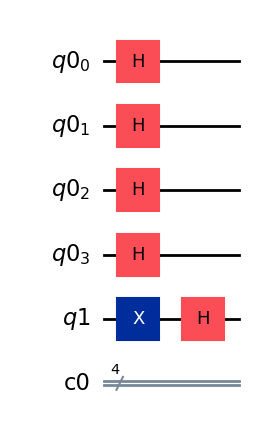

In [8]:
qc.h(qr)
qc.x(oq)
qc.h(oq)
qc.draw(output="mpl")

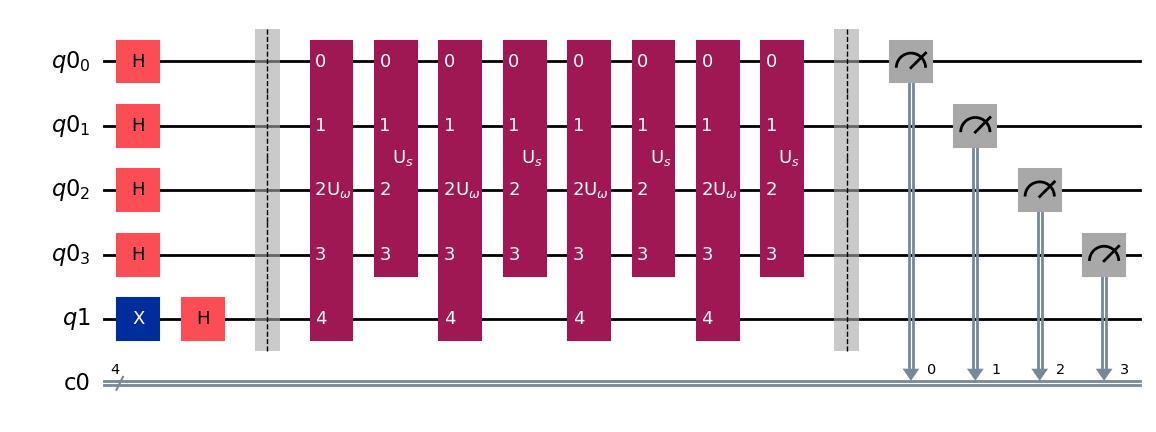

In [9]:
qc.barrier()
qc = grover_operator(qc,n,iterations,"1001")
qc.barrier()
qc.measure(qr,cr)
qc.draw(output="mpl")

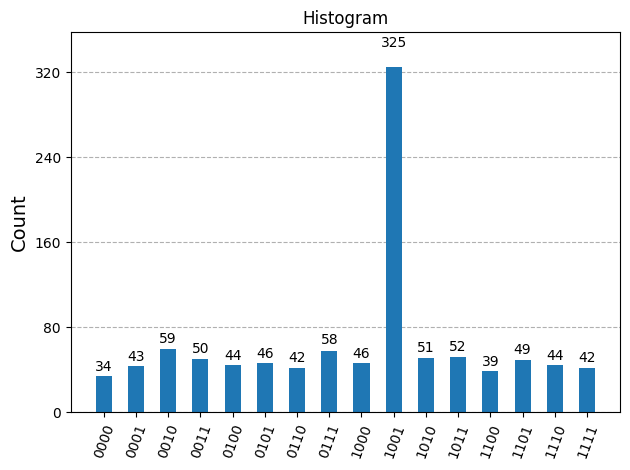

In [10]:
# Transpile for simulator
simulator = AerSimulator()
qc = transpile(qc, simulator)
results = simulator.run(qc).result()
counts = results.get_counts()
plot_histogram(counts, title="Histogram")

# Sudoku

In [11]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)


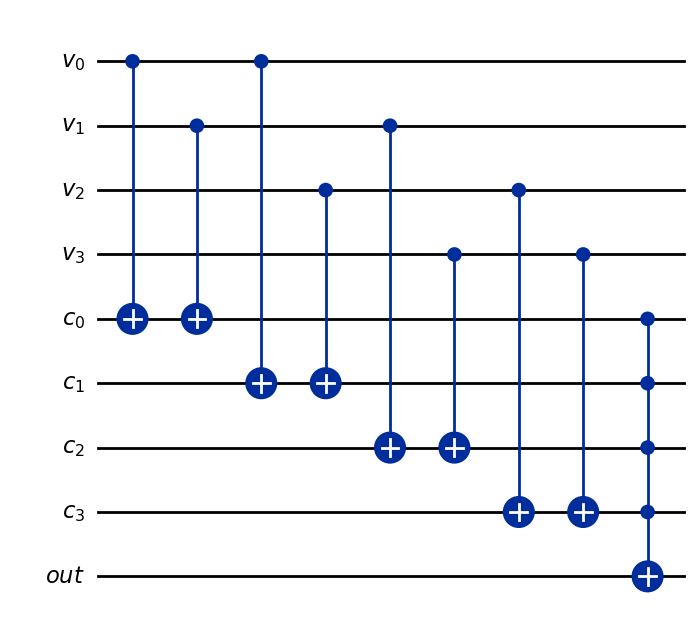

In [12]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
mct_gate = MCXGate(4)
qc.append(mct_gate, [4,5,6,7,8])

fig = qc.draw(output="mpl")
fig.savefig(
        get_path("clause_list"),
        bbox_inches='tight',
        pad_inches=0)
display(fig)

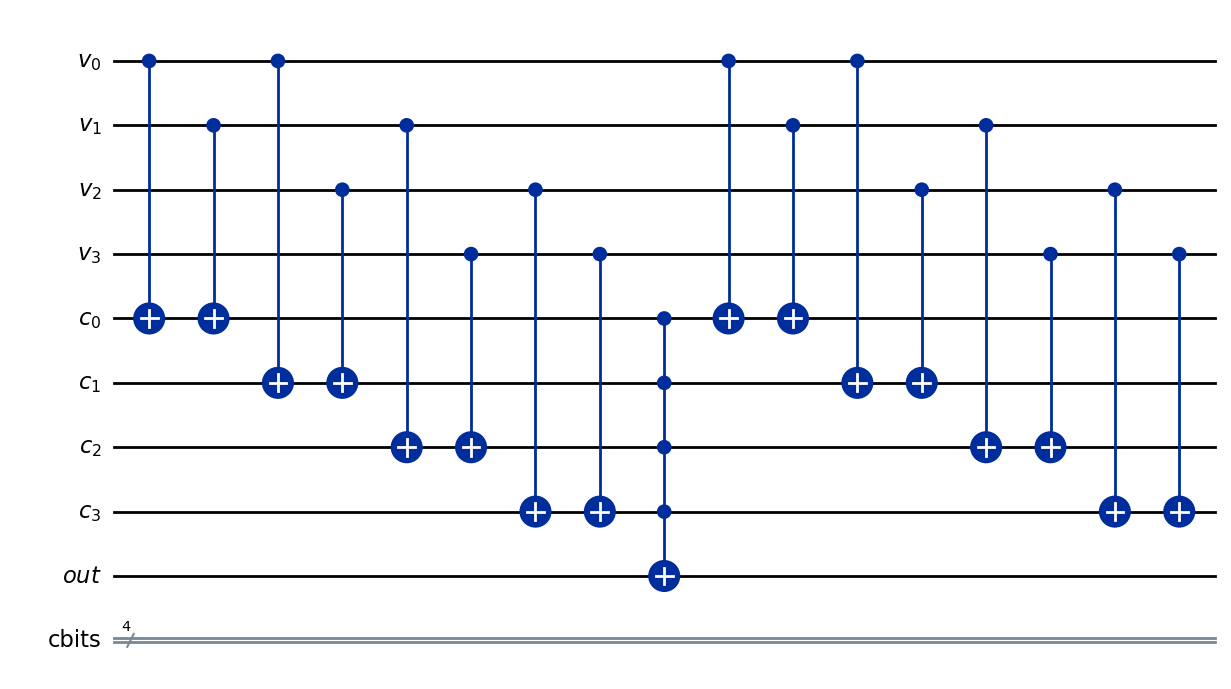

In [13]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    mct_gate = MCXGate(4)
    qc.append(mct_gate, [4,5,6,7,8])

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
fig = qc.draw(output="mpl")
fig.savefig(
        get_path("sudoku_oracle"),
        bbox_inches='tight',
        pad_inches=0)
display(fig)

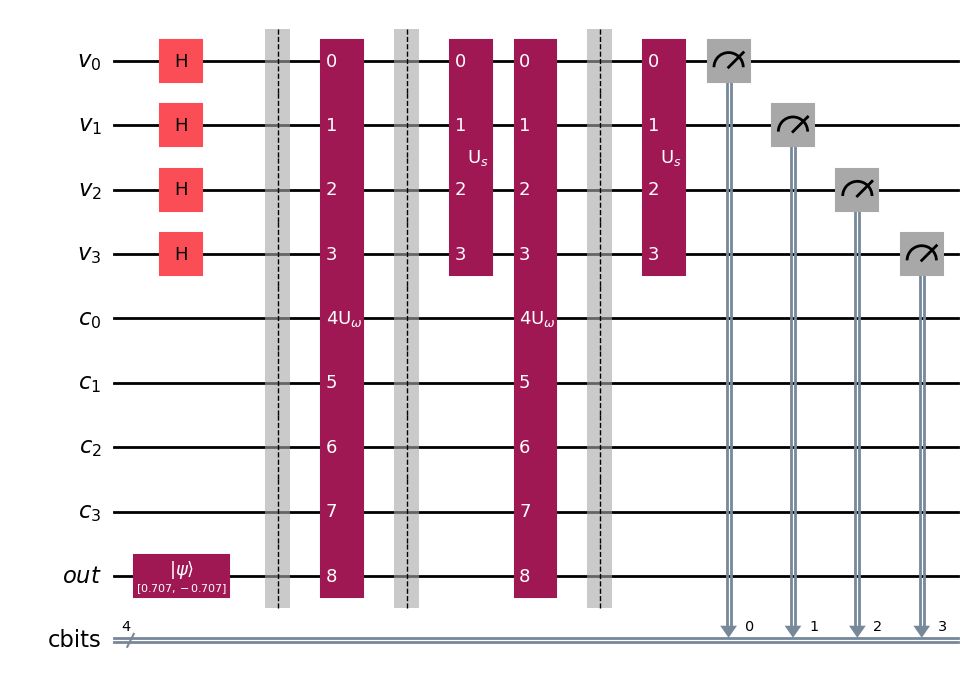

In [14]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

def sudoku_oracle(clause_list, number_of_variables, number_of_clauses):
    var_qubits = QuantumRegister(number_of_variables, name='v')
    clause_qubits = QuantumRegister(number_of_clauses, name='c')
    output_qubit = QuantumRegister(1, name='out')
    qc = QuantumCircuit(var_qubits,clause_qubits,output_qubit)                       
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    mct_gate = MCXGate(len(clause_list))
    qc.append(mct_gate, [clause_qubits[i] for i in range(len(clause_list))]+[output_qubit[0]])

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1
    oracle = qc.to_gate()
    oracle.name = "U$_\\omega$"
    return oracle

        
 

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    
    # Step 1: |s> -> |00..0>
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Step 2: Multi-controlled Z
    qc.h(nqubits-1)
    qc.append(MCXGate(nqubits - 1), list(range(nqubits)))
    qc.h(nqubits-1)
    
    # Step 3: Undo X
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Step 4: |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s
    
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]
number_of_clauses = len(clause_list)
number_of_variables = 4

var_qubits = QuantumRegister(number_of_variables, name='v')
clause_qubits = QuantumRegister(number_of_clauses, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(number_of_variables, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

qc.draw(fold=-1)

## First Iteration
# Apply our oracle
qc.append(sudoku_oracle(clause_list, number_of_variables, number_of_clauses), [var_qubits[q] for q in range(0,number_of_variables)]+
                          [clause_qubits[q] for q in range(0,number_of_clauses)]+
                          [output_qubit])
qc.barrier()  # for visual separation
qc.draw(fold=-1)


qc.append(diffuser(4), [var_qubits[i] for i in range(number_of_variables)])
qc.draw(fold=-1)


## Second Iteration
qc.append(sudoku_oracle(clause_list, number_of_variables, number_of_clauses), [var_qubits[q] for q in range(0,number_of_variables)]+
                          [clause_qubits[q] for q in range(0,number_of_clauses)]+
                          [output_qubit])
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [var_qubits[i] for i in range(number_of_variables)])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

fig = qc.draw(output="mpl")
fig.savefig(
        get_path("full_sudoku"),
        bbox_inches='tight',
        pad_inches=0)
display(fig)

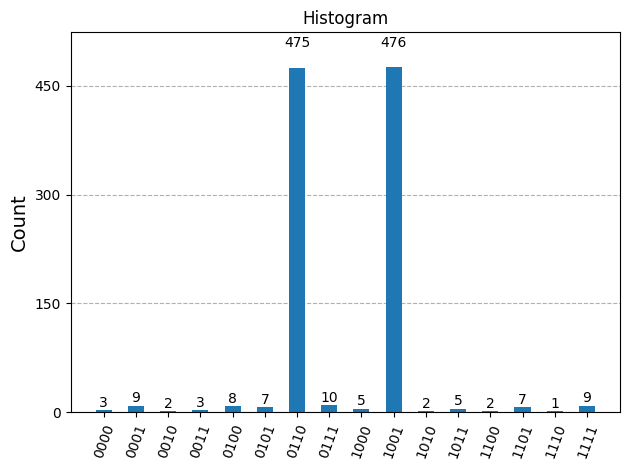

In [15]:
# Transpile for simulator
simulator = AerSimulator()
qc = transpile(qc, simulator)
results = simulator.run(qc).result()
counts = results.get_counts()
plot_histogram(counts, title="Histogram")